# Inversão do Te  do Havaí

In [1]:
from __future__ import division, print_function
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
x, topo = np.loadtxt('../DiaDois/Flexura/Oahu_profile.txt', unpack=True)

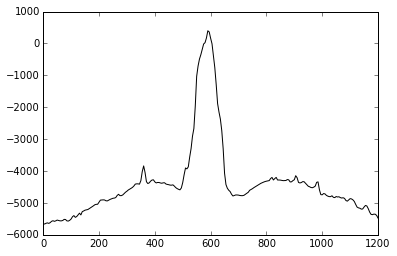

In [3]:
plt.plot(x, topo, '-k')

## Desafio: Estimar o regional com uma parábola

In [4]:
from fatiando.inversion import Misfit

In [5]:
class Parabola(Misfit):
    
    def __init__(self, x, y):
        super(Parabola, self).__init__(data=y, nparams=3, islinear=True)
        self.x = x
        
    def predicted(self, p):
        a, b, c = p
        return a*self.x**2 + b*self.x + c
    
    def jacobian(self, p):
        A = np.empty((self.ndata, self.nparams))
        A[:, 0] = self.x**2
        A[:, 1] = self.x
        A[:, 2] = 1
        return A

In [6]:
par = Parabola(x, topo).fit()

In [7]:
par.estimate_

array([ -6.73787189e-03,   8.42348926e+00,  -6.19822821e+03])

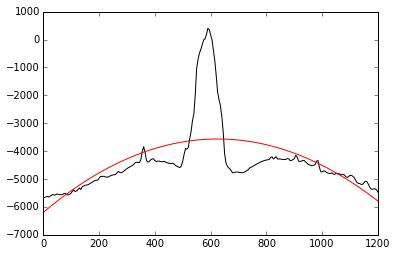

In [8]:
plt.plot(x, topo, '-k')
plt.plot(x, par.predicted(), '-r')

## Ajuste robusto

In [85]:
par_robusto = Parabola(x, topo).fit()

In [86]:
r = par_robusto.residuals()

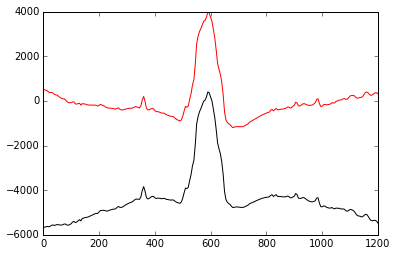

In [87]:
plt.plot(x, topo, '-k')
plt.plot(x, r, '-r')

In [88]:
pesos = 1/np.abs(r)
pesos[r < 1e-5] = 1e5

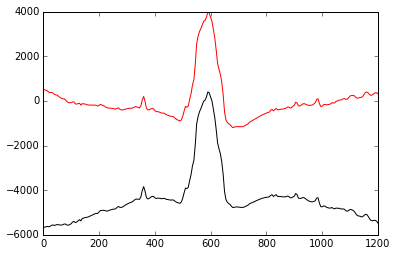

In [89]:
plt.plot(x, topo, '-k')
plt.plot(x, r, '-r')

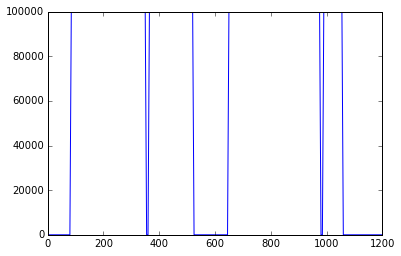

In [90]:
plt.plot(x, pesos, '-b')

In [91]:
for i in xrange(20):
    r = par_robusto.residuals()
    pesos = 1/np.abs(r)
    pesos[np.abs(r) < 1e-5] = 1e5
    par_robusto.set_weights(pesos).fit()

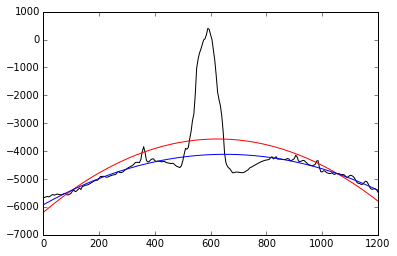

In [54]:
plt.plot(x, topo, '-k')
plt.plot(x, par.predicted(), '-r')
plt.plot(x, par_robusto.predicted(), '-b')

In [16]:
topo_res = topo - par_robusto.predicted()

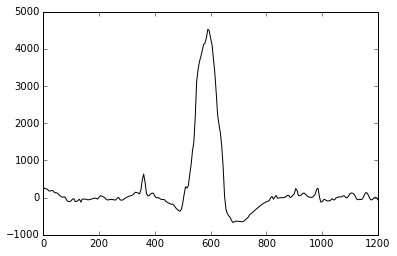

In [17]:
plt.plot(x, topo_res, '-k')

## Desafio: Inversão para o Te usando flexura

In [18]:
from scipy import sparse
from scipy.sparse.linalg import dsolve

In [19]:
class FlexNum3(object):    
    drho = 2300.0
    g = 10.0
    E = 1.0E11
    nu = 0.25
    V0 = -1.0E13    
    
    def __init__(self, x, p, Te):
        self.x = x
        self.p = p
        self.dx = x[1]-x[0]
        self.N = p.size
        self.Te = Te
        
    def monta_roda(self):
        D = self.E*self.Te**3/(12*(1-self.nu**2))
        N,dx,drho,g = self.N,self.dx,self.drho,self.g
        
        Alin = np.arange(N)
        Alin = np.append(Alin,np.arange(0,N-1))
        Alin = np.append(Alin,np.arange(1,N))
        Alin = np.append(Alin,np.arange(0,N-2))
        Alin = np.append(Alin,np.arange(2,N))
        
        Acol = np.arange(N)
        Acol = np.append(Acol,np.arange(1,N))
        Acol = np.append(Acol,np.arange(0,N-1))
        Acol = np.append(Acol,np.arange(2,N))
        Acol = np.append(Acol,np.arange(0,N-2))
        
        Aval = np.zeros(N) + 6*D + dx**4*drho*g
        Aval = np.append(Aval,np.zeros(N-1)-4*D)
        Aval = np.append(Aval,np.zeros(N-1)-4*D)
        Aval = np.append(Aval,np.zeros(N-2)+D)
        Aval = np.append(Aval,np.zeros(N-2)+D)
        
        self.A = sparse.csr_matrix((Aval,(Alin,Acol)), shape=(N,N))
        
        self.w = dsolve.spsolve(self.A,self.p*dx**4)

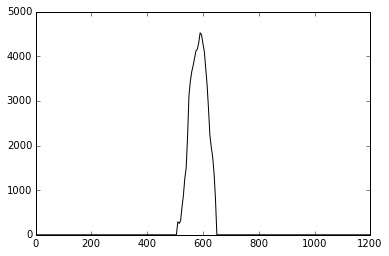

In [20]:
h_load = np.copy(topo_res)
h_load[(x < 510) | (x > 649)] = 0

plt.plot(x, h_load, '-k')

In [21]:
p = -h_load*(2700-1000)*10
flex = FlexNum3(x*1000, p, 50000)

In [22]:
flex.monta_roda()

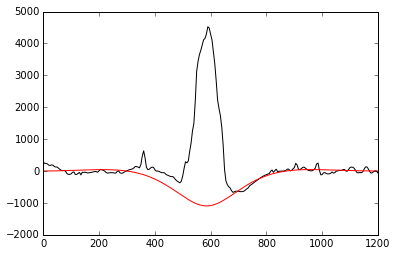

In [23]:
plt.plot(x, topo_res, '-k')
plt.plot(x, flex.w, '-r')

In [24]:
class Dummy(object):
    def __init__(self, *args):
        pass
    def hard_reset(self):
        pass

In [93]:
class FlexTe(Misfit):
    
    def __init__(self, x, topo, flex):
        self.hessian = Dummy()
        super(FlexTe, self).__init__(data=topo, nparams=1, islinear=False)
        self.x = x
        self.flex = flex
        
    def predicted(self, p):
        self.flex.Te = p[0]
        self.flex.monta_roda()
        return self.flex.w
    
    def jacobian(self, p):
        return np.empty((self.ndata, 1))
        

In [94]:
solver = FlexTe(x, topo_res, flex)

In [95]:
solver.config('acor', bounds=[30e3, 100e3]).fit()

In [96]:
solver.estimate_

array([ 99999.99999969])

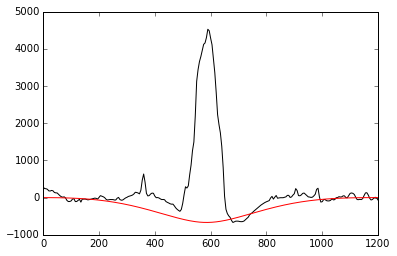

In [97]:
plt.plot(x, topo_res, '-k')
plt.plot(x, solver.predicted(), '-r')

In [98]:
r = solver.residuals()
pesos = 1/np.abs(r)
pesos[r < 1e-5] = 1e5

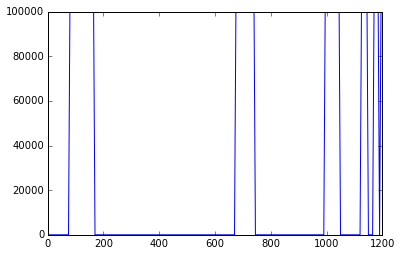

In [99]:
plt.plot(x, pesos)

In [100]:
for i in xrange(5):
    r = solver.residuals()
    pesos = 1/np.abs(r)
    pesos[np.abs(r) < 1e-5] = 1e5
    solver.set_weights(pesos).fit()

In [102]:
solver.estimate_

array([ 99999.99998852])

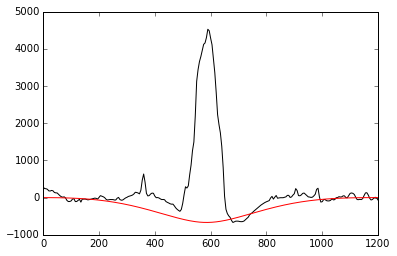

In [103]:
plt.plot(x, topo_res, '-k')
plt.plot(x, solver.predicted(), '-r')